In [911]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.feature_selection import f_classif, VarianceThreshold, mutual_info_classif, RFE, SelectKBest, chi2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [912]:
df_insurance = pd.read_csv('./insurance.csv')
df_insurance = df_insurance.drop_duplicates()

def condition(df_insurance, median_value):
    if df_insurance['insurance_cost'] <= median_value:
        return 0
    else:
        return 1

median_value = df_insurance['insurance_cost'].median()
print(median_value)

# create a new column
df_insurance['insurance_cost_binary'] =  df_insurance.apply(lambda row: condition(row, median_value), axis=1)

# drop the column
df_insurance = df_insurance.drop(columns=['insurance_cost'])

#df_insurance = df_insurance.drop(columns=['children'])

# these columns mess up the result
#df_insurance['age_smoker'] =  (df_insurance['age'] * df_insurance['smoker'].map({'yes': 1, 'no': 0})).values.reshape(-1, 1)
#df_insurance['bmi_smoker'] =  (df_insurance['bmi'] * df_insurance['smoker'].map({'yes': 1, 'no': 0})).values.reshape(-1, 1)

#df_insurance = df_insurance.drop(columns=['smoker'])

#bins = [0, 20, 30, 40, 50, 60, 70, 200]
#labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71+']

#df_insurance['age_bucket'] = pd.cut(df_insurance['age'], bins=bins, labels=labels, right=False)

# drop the column
#df_insurance = df_insurance.drop(columns=['age'])


9386.1613


In [913]:
def train_test_split_model():
    y = df_insurance['insurance_cost_binary']
    X = df_insurance.drop('insurance_cost_binary', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

    return X_train, X_test, y_train, y_test

In [914]:
def print_fits_vs_folds(search) :
    param_combinations = np.prod([len(values) for values in search.param_grid.values()])
    cv_folds = search.cv if isinstance(search.cv, int) else 5
    total_fits = param_combinations * cv_folds

    print(f"Total num of fits: {total_fits} (parameter combinations: {param_combinations}, CV folds: {cv_folds})")

In [915]:
def model_performance(search, X_train, y_train, X_test, y_test) :
    y_train_pred = search.predict(X_train)
    y_test_pred = search.predict(X_test)

    metrics = {
        'R²': r2_score,
        'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error
    }

    results = {
        'Metric': ['R²', 'RMSE', 'MAE'],
        'Training Set': [metrics['R²'](y_train, y_train_pred),
                  metrics['RMSE'](y_train, y_train_pred),
                  metrics['MAE'](y_train, y_train_pred)],
        'Test Set': [metrics['R²'](y_test, y_test_pred),
                 metrics['RMSE'](y_test, y_test_pred),
                 metrics['MAE'](y_test, y_test_pred)]
    }

    print("\nModel performance:\n")
    print(pd.DataFrame(results).round(3).to_string(index=False))

In [916]:
def print_results(search, X_train, y_train, X_test, y_test) :
    print("Best Parameters:", search.best_params_)
    print(f"Best R² score = %0.3f:" % search.best_score_)

    model_performance(search, X_train, y_train, X_test, y_test)

In [917]:
def plot_prediction_vs_actual(y_test, y_test_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Charges')
    plt.ylabel('Predicted Charges')
    plt.title('Predicted vs Actual Charges (Test Set)')
    plt.close()

In [918]:
def feature_importance(best_model):
    reduce_dim = best_model.named_steps['reduce_dim']
    if isinstance(reduce_dim, PCA):
        print("\nPCA used: Feature importances/coefficient not directly available.")
    else:
        regressor = best_model.named_steps['ttr'].regressor_
        feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
        if isinstance(reduce_dim, RFE):
            selected_features = [feature_names[i] for i in range(len(feature_names)) if reduce_dim.support_[i]]
        else:
            selected_features = feature_names

        values = (regressor.feature_importances_ if hasattr(regressor, 'feature_importances_')
                  else regressor.coef_ if hasattr(regressor, 'coef_')
                  else [1.0] * len(selected_features))
        label = ("Feature Importances" if hasattr(regressor, 'feature_importances_')
                 else "Feature Coefficients" if hasattr(regressor, 'coef_')
                 else "Feature Ranking (no importance/coefficients available)")

        print("\nFeature importance:\n")
        feature_df = pd.DataFrame({
            'Feature': selected_features,
            label: values
        }).sort_values(by=label, key=abs, ascending=False)

        print(feature_df)

In [919]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):

    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)

    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)

    return _mse, _mae, _r2

In [920]:
df_insurance

,age,gender,bmi,children,smoker,region,insurance_cost_binary
0,18,male,33.770,1,no,southeast,0
1,18,male,34.100,0,no,southeast,0
2,18,female,26.315,0,no,northeast,0
3,18,female,38.665,2,no,northeast,0
4,18,female,35.625,0,no,northeast,0
...,...,...,...,...,...,...,...
1333,64,female,31.825,2,no,northeast,1
1334,64,female,26.885,0,yes,northwest,1
1335,64,male,26.410,0,no,northeast,1
1336,64,male,36.960,2,yes,southeast,1


In [921]:
df_insurance['insurance_cost_binary'].value_counts()

insurance_cost_binary
0    669
1    668
Name: count, dtype: int64

In [922]:
df_insurance.isna().sum()

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

,age,bmi,children,insurance_cost_binary
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,0.499626
std,14.044333,6.100468,1.205571,0.500187
min,18.000000,15.960000,0.000000,0.000000
25%,27.000000,26.290000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,0.000000
75%,51.000000,34.700000,2.000000,1.000000
max,64.000000,53.130000,5.000000,1.000000


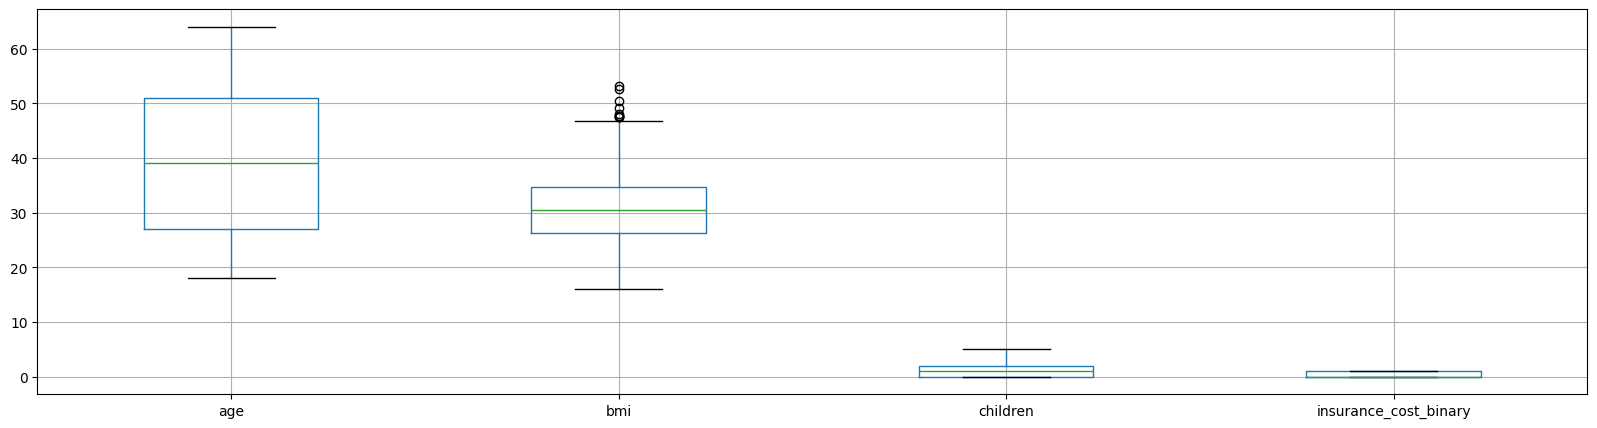

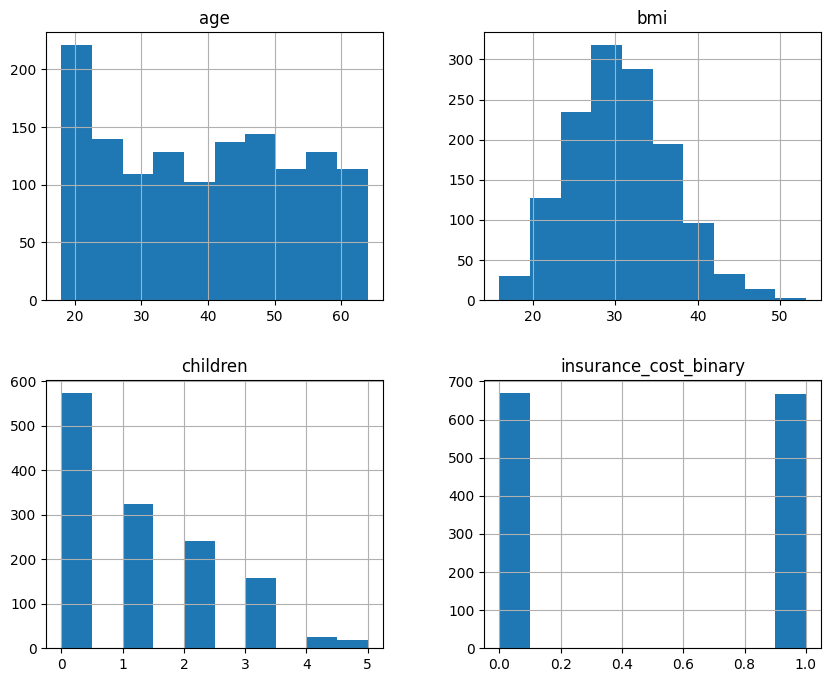

In [923]:
df_insurance.boxplot(figsize=(20,5))
df_insurance.hist(bins=10, figsize=(10, 8))
df_insurance.describe()

In [924]:
#df_insurance[df_insurance.children == 0]

In [925]:
X_train, X_test, y_train, y_test = train_test_split_model()

In [926]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [927]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ('categorical', Pipeline([
            ('encode', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')), # ordinal encoding does worst
            ("scaler", MinMaxScaler())
        ]), ['gender', 'region', 'smoker']),
    ],
    remainder=Pipeline([
        ('default_scale', RobustScaler())  # Default scaling - clip outliers
    ]),
    verbose_feature_names_out=True
).set_output(transform="pandas")

In [928]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr',RandomForestRegressor(random_state=42, warm_start=True))
                      ], memory='sklearn_cache'
               )

In [929]:
search_space = [
    {
        'reduce_dim': Categorical(
            [
                RFE(svm.SVR(kernel='linear', C=0.01, epsilon=0.5, max_iter=50000)) # speed up things and brought it from 71 to 75 and down to 1 min
            ]),
        # VALUES BELOW BRING THE SCORE OF R2 UP FROM 71 TO 74 - used from the previous task
        'ttr__max_depth': Integer(5, 10),  # Range for max_depth
        'ttr__n_estimators': Integer(50, 200),  # Range for n_estimators
    }
]

search = BayesSearchCV(pipe, search_spaces=search_space, n_points=3, n_iter=50, cv=kfold, n_jobs=1, refit=True, scoring='r2', verbose=0)
search.fit(X_train, y_train)

print_results(search, X_train, y_train, X_test, y_test)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [RFE(estimator=SVR(C=0.01, epsilon=0.5, kernel='linear', max_iter=50000)), 5, 200] before, using random point [RFE(estimator=SVR(C=0.01, epsilon=0.5, kernel='linear', max_iter=50000)), 9, 171]
  warnings.warn(
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [RFE(estimator=SVR(C=0.01, epsilon=0.5, kernel='linear', max_iter=50000)), 5, 200] before, using random point [RFE(estimator=SVR(C=0.01, epsilon=0.5, kernel='linear', max_iter=50000)), 6, 53]
  warnings.warn(
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\P

Best Parameters: OrderedDict([('reduce_dim', RFE(estimator=SVR(C=0.01, epsilon=0.5, kernel='linear', max_iter=50000))), ('ttr__max_depth', 5), ('ttr__n_estimators', 101)])
Best R² score = 0.757:

Model performance:

Metric  Training Set  Test Set
    R²         0.805     0.734
  RMSE         0.221     0.258
   MAE         0.106     0.124


In [930]:
from sklearn.feature_selection import f_regression

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', SelectKBest(score_func=f_regression)),
                       ('ttr', LinearRegression(n_jobs=-1))
                      ], memory='sklearn_cache'
               )

In [931]:
search_space_lr= [{
    'reduce_dim__k': [3, 4, 5],  # Tune number of features (or all features)
}]

search = BayesSearchCV(pipe, search_spaces=search_space_lr, n_points=3, n_iter=50, cv=kfold, n_jobs=1, refit=True, scoring='r2', verbose=0)
search.fit(X_train, y_train)

print_results(search, X_train, y_train, X_test, y_test)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [3] before, using random point [3]
  warnings.warn(
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [3] before, using random point [4]
  warnings.warn(
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [3] before, using random point [4]
  warnings.warn(
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\opt

Best Parameters: OrderedDict([('reduce_dim__k', 3)])
Best R² score = 0.532:

Model performance:

Metric  Training Set  Test Set
    R²         0.535     0.528
  RMSE         0.341     0.344
   MAE         0.279     0.289


In [932]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', SVR())
                      ], memory='sklearn_cache'
               )

In [933]:
search_space =[ {  'reduce_dim': Categorical([PCA(n_components=0.80, random_state=42),
                               RFE(svm.SVR(kernel='linear', C=0.01, epsilon=0.5, max_iter=50000)), # speed up things and brought it from 71 to 74 and down to 1 min
                               RFE(estimator=LinearRegression(n_jobs=-1), n_features_to_select=0.4)
                             ])
            }]

search = BayesSearchCV(pipe, search_spaces=search_space, n_points=3, n_iter=50, cv=kfold, n_jobs=1, refit=True, scoring='r2', verbose=0)
search.fit(X_train, y_train)

print_results(search, X_train, y_train, X_test, y_test)

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_

C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [RFE(estimator=LinearRegression(n_jobs=-1), n_features_to_select=0.4)] before, using random point [PCA(n_components=0.8, random_state=42)]
  warnings.warn(
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [RFE(estimator=LinearRegression(n_jobs=-1), n_features_to_select=0.4)] before, using random point [RFE(estimator=SVR(C=0.01, epsilon=0.5, kernel='linear', max_iter=50000))]
  warnings.warn(
C:\Users\jorgeblx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The

Best Parameters: OrderedDict([('reduce_dim', RFE(estimator=LinearRegression(n_jobs=-1), n_features_to_select=0.4))])
Best R² score = 0.720:

Model performance:

Metric  Training Set  Test Set
    R²         0.725     0.698
  RMSE         0.262     0.275
   MAE         0.153     0.153


In [934]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, SVR_best_model)

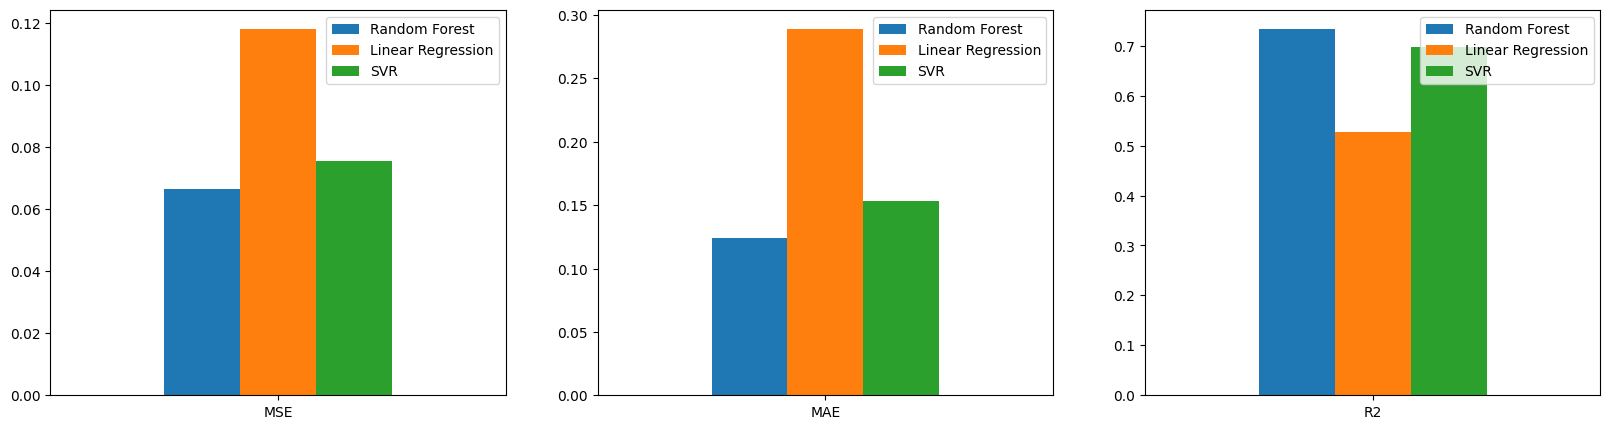

In [935]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SVR': SVR_mse }, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SVR': SVR_mae }, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SVR': SVR_r2 }, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()